# Object Removal and Impainting using Generative Adverserial Network
## Project by: Anna Wang, Jimmy Yang and Phillip Chen


# Abstract
## TO DO 

# 1 Environment

run the following cells to set up your environment

In [33]:
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2 Importing Dataset

Our dataset comes from Hugging Face Dataset cats_vs_dogs: https://huggingface.co/datasets/microsoft/cats_vs_dogs

Run the cell below to set up datasets in your environment, further instructions for how to import the dataset are included in the README

In [ ]:
# uncomment code blocks below when needed
# !huggingface-cli login
# !pip install datasets

### 2.1 Importing Cats vs. Dogs Dataset

In [8]:
from datasets import load_dataset

ds = load_dataset("microsoft/cats_vs_dogs")

print(ds['train'])

Dataset({
    features: ['image', 'labels'],
    num_rows: 23410
})


### 2.2 Filtering Dataset by Cats and Dogs

In [25]:
# filtering data by cats and dogs
data = ds['train']
dogs = data.filter(lambda isDog: isDog['labels'] == 1)
cats = data.filter(lambda isDog: isDog['labels'] == 0)
print("Dataset size: " + str(len(data)))

print("Total dataset size:", len(data))
print("Dogs:", len(dogs))
print("Cats:", len(cats))

Dataset size: 23410
Total dataset size: 23410
Dogs: 11669
Cats: 11741


### 2.3 Splitting each class into training, validation and test sets

Training dataset size: 9392
Validation dataset size: 1174
Test dataset size: 1175


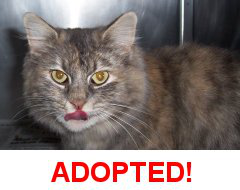

In [28]:
# Split the dataset
train_test_split = cats.train_test_split(test_size=0.2, seed=42)
test_val_split = train_test_split['test'].train_test_split(test_size=0.5, seed=42)
train_dataset = train_test_split['train']['image']
val_dataset = test_val_split['train']['image']
test_dataset = test_val_split['test']['image']

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
train_dataset[0]

# 3 Creating Data Loaders

### 3.1 Masks WRITING TODO

In [ ]:
hole_size = 20

def create_masks(N, im_h, im_w):
    x = int((im_w - hole_size) / 2.0)
    y = int((im_h - hole_size) / 2.0)
    mask = torch.zeros((1, im_h, im_w))
    mask[0, y : y + hole_size, x : x + hole_size] = 1
    masks = mask.repeat_interleave(N, dim=0)
    # masks = torch.cat(masks, dim=0)
    return masks.unsqueeze(1)

### 3.2 Creating Cat Dataset Definition

The following class defines our Cat Dataset 

In [34]:
class CatDataset(Dataset):
    def __init__(self, all_imgs, transforms=None) -> None:
        super().__init__()
        self.transforms = transforms
        self.all_imgs = all_imgs


    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, index):
        image = self.all_imgs[index]

        transformed_img = self.transforms(image) if self.transforms else image
        # transformed_img = transformed_img[0]

        # create deep copy of image for transformation
        ground_truth_image = deepcopy(transformed_img)

        # # change center depending on where to randomize
        mask = create_masks(1, 64, 64)[0]
        transformed_img = (1 - mask) * transformed_img
        # transformed_img[:, 10:20, 10:20] = torch.rand((3, 10, 10))
        #transformed_img[:, 96:160, 96:160] = torch.rand((3, 64, 64))

        return transformed_img, ground_truth_image

### 3.3 Transformations TO DO FIX WRITING

We experimented with several transformations, including different versions of crops and normalizations. The model performance was best when we simply converted pixel values into [0, 1] range and resized the entire image to 64x64 rather than taking a crop of the image.

In [35]:
transforms = v2.Compose([
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    v2.Resize(size=(64, 64))
])

transformed_train_dataset = CatDataset(train_dataset, transforms=transforms)
transformed_val_dataset = CatDataset(val_dataset, transforms=transforms)
transformed_test_dataset = CatDataset(test_dataset, transforms=transforms)

### 3.4 Explore Dataset

In [36]:
item0, item1, item2 = transformed_train_dataset[10], transformed_train_dataset[1], transformed_train_dataset[2]

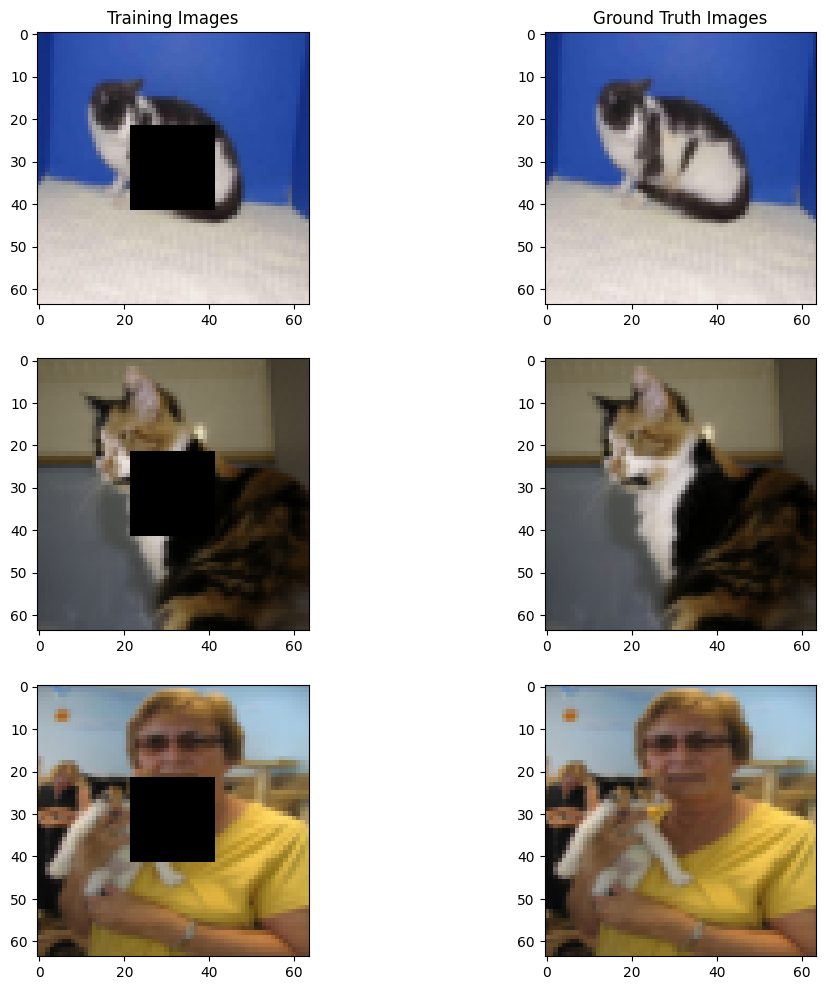

In [37]:
# train image
f, ax = plt.subplots(3, 2, figsize=(12, 12))
ax[0, 0].imshow(np.transpose(item0[0], (1, 2, 0)))
ax[0, 1].imshow(np.transpose(item0[1], (1, 2, 0)))
ax[1, 0].imshow(np.transpose(item1[0], (1, 2, 0)))
ax[1, 1].imshow(np.transpose(item1[1], (1, 2, 0)))
ax[2, 0].imshow(np.transpose(item2[0], (1, 2, 0)))
ax[2, 1].imshow(np.transpose(item2[1], (1, 2, 0)))

ax[0, 0].set_title("Training Images");
ax[0, 1].set_title("Ground Truth Images");


### 3.5 Setup Dataloader

In [38]:
train_dataset, val_dataset, test_dataset = transformed_train_dataset, transformed_val_dataset, transformed_test_dataset

In [39]:
BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 4 GAN Model

GANS TO DO

### 4.1 Generator

In [ ]:
class Generator(nn.Module):

    def __init__(self, im_channels):
        super().__init__()
        
        # Encoder
        self.conv1 = nn.Conv2d(im_channels + 1, 64, 5, stride=1, padding=2)

        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)

        self.conv3 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 256, 3, stride=1, padding=1)

        # Dilation
        self.conv5 = nn.Conv2d(256, 256, 3, stride=1, padding=1, dilation=2)
        self.conv6 = nn.Conv2d(256, 256, 3, stride=1, padding=1, dilation=4)

        self.conv7 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        
        # Decoder
        self.deconv8 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.conv9 = nn.Conv2d(128, 128, 3, stride=1, padding=1)

        self.deconv10 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.conv11 = nn.Conv2d(64, 32, 3, stride=1, padding=1)
        self.conv12 = nn.Conv2d(32, 3, 3, stride=1, padding=1)

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(256)
        self.bn6 = nn.BatchNorm2d(256)
        self.bn7 = nn.BatchNorm2d(256)
        self.bn8 = nn.BatchNorm2d(128)
        self.bn9 = nn.BatchNorm2d(128)
        self.bn10 = nn.BatchNorm2d(64)
        self.bn11 = nn.BatchNorm2d(32)

        self.relu = torch.nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, x):
         # encode
        x1 = self.bn1(self.relu(self.conv1(x)))
        x2 = self.bn2(self.relu(self.conv2(x1)))
        x3 = self.bn3(self.relu(self.conv3(x2)))
        x4 = self.bn4(self.relu(self.conv4(x3)))
        x5 = self.bn5(self.relu(self.conv5(x4)))
        x6 = self.bn6(self.relu(self.conv6(x5)))
        x7 = self.bn7(self.relu(self.conv7(x6)))
        x8 = self.bn8(self.relu(self.deconv8(x7)))
        x9 = self.bn9(self.relu(self.conv9(x8)))
        x10 = self.bn10(self.relu(self.deconv10(x9)))
        x11 = self.bn11(self.relu(self.conv11(x10)))

        output = self.sigmoid(self.conv12(x11))
        return output


### 4.2 Discriminator

In [40]:
class Discriminator(nn.Module):
    """
        This is the discriminator class. The discriminator takes in an image and its job is to classify whether the image is generated(fake) 
        or real (non-generated).

        The architecture of the network is the same as a simple CNN classifier
        with the following architecture:
            1) 4x64x64   -> 64x32x32
            2) 64x32x32  -> 128x16x16
            3) 128x16X16 -> 256x8x8
            4) 256x8x8   -> 512x4x4
            5) 512x4x4   -> 512x1x1
            6) 512 -> 512
            7) 512 -> 512
            8) 512 -> 256
            9) 256 -> 10
            10) 10 -> 1
    """
    def __init__(self):
        super().__init__() # wtf does this do
        # conv layers
        self.conv1 = nn.Conv2d(4, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)

        # batch norm layers
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)

        # linear layers
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 10)
        self.fc5 = nn.Linear(10, 1)

        # non-learnable layers
        self.relu = nn.ReLU()
        self.down_sample = nn.AvgPool2d(2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1)) # self.max_pool = nn.MaxPool2d(4)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # conv layers
        x = self.down_sample(self.conv1(x))
        x = self.relu(x)
        x = self.bn1(x)

        x = self.down_sample(self.conv2(x))
        x = self.relu(x)
        x = self.bn2(x)

        x = self.down_sample(self.conv3(x))
        x = self.relu(x)
        x = self.bn3(x)

        x = self.down_sample(self.conv4(x))
        x = self.relu(x)
        x = self.bn4(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) # x = x.view(x.size(0), x.size(1))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        x = self.sigmoid(x)
        return x

In [41]:
model = Discriminator()

# Create a random input tensor with the specified shape (4x64x64)
input_tensor = torch.randn(1, 4, 64, 64)

# Forward pass to get the output tensor
output_tensor = model(input_tensor)
output_tensor.shape

torch.Size([1, 1])